In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import statistics
import contextily as cx
from haversine import haversine, Unit
import haversine as hs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import folium
import statsmodels.api as sm

In [2]:
mypath = '../trips/'

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
def filterSubstr(lists, substr):
    return [x for x in lists if substr in x]

searchString = '2022_09_13'
onlyfiles_14_09 = filterSubstr(onlyfiles, searchString)
onlyfiles_14_09

searchString = '_09_0'
onlyfiles = filterSubstr(onlyfiles_14_09, searchString)
onlyfiles

['2022_09_13_LA2 Logi Jeep_09_06_09_22_41ab7e72-261b-4d62-9c98-e08ba9481c14.csv',
 '2022_09_13_PS Skylark Test_09_09_09_23_23351042-777c-4a84-9d81-b74d77210823.csv',
 '2022_09_13_RW2 Logi Jeep_09_06_09_22_d8471341-6779-4d27-8ca6-4ef30c5f93a0.csv']

In [5]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)
alldata['data'] = alldata['Time[ms]'].dt.date
alldata["data"] = pd.to_datetime(alldata["data"])
alldata

,Time[ms],Latitude,Longitude,Speed[m/s],Distance,Altitude[m],Flag,Acceleration[m/s^2],AccWork[J],AeroWork[J],...,TotalWork[J],StandStillTime[s],Fuel[l],CO2[kg],AccECE[%],AeroECE[%],STSECE[%],WorkECE[%],driver,data
0,2022-09-13 09:06:09,53.560271,9.981096,2.35,NaN,58.6,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA,2022-09-13
1,2022-09-13 09:06:10,53.560165,9.981049,4.08,4.08,58.7,0,1.73,7258.0,32.0,...,9353.205,0.0,0.001048,0.002791,300.000000,18.242585,0.000000,26.968151,LA,2022-09-13
2,2022-09-13 09:06:11,53.560057,9.981008,7.24,7.24,58.7,0,3.16,23340.0,182.0,...,24912.000,0.0,0.002790,0.007433,300.000000,39.425086,0.000000,101.533397,LA,2022-09-13
3,2022-09-13 09:06:12,53.559968,9.980970,5.70,5.70,58.9,0,-1.54,-13003.0,88.0,...,0.000,0.0,0.000000,0.000000,300.000000,36.967118,0.000000,96.407210,LA,2022-09-13
4,2022-09-13 09:06:13,53.559989,9.980970,2.74,2.74,58.9,0,-2.96,-16302.0,9.0,...,0.000,0.0,0.000000,0.000000,300.000000,36.225552,0.000000,95.400626,LA,2022-09-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2337,2022-09-13 09:22:28,53.560331,9.981155,2.60,2.60,53.6,0,-0.47,-2657.0,11.0,...,0.000,0.0,0.000000,0.000000,103.022404,60.881518,26.843304,107.072281,RW,2022-09-13
2338,2022-09-13 09:22:29,53.560342,9.981113,2.28,2.28,59.1,4,-0.32,-1557.0,7.0,...,0.000,0.0,0.000000,0.000000,99.799386,60.784688,26.736830,104.423180,RW,2022-09-13
2339,2022-09-13 09:22:30,53.560349,9.981103,0.68,0.68,59.1,0,-1.60,-4722.0,0.0,...,0.000,0.0,0.000000,0.000000,97.539619,60.712583,26.606931,102.431802,RW,2022-09-13
2340,2022-09-13 09:22:31,53.560347,9.981101,0.61,0.61,59.1,0,-0.07,-91.0,0.0,...,87.000,0.0,0.000010,0.000026,98.659008,60.694480,26.480764,103.517185,RW,2022-09-13


In [6]:
alldata_SORTED = alldata.sort_values(by = 'Time[ms]').reset_index(drop=True)
alldata_SORTED_cut = alldata_SORTED.dropna().reset_index(drop=True)
alldata_SORTED_cut['Time'] = pd.to_datetime(alldata_SORTED_cut['Time[ms]'].dt.strftime('%Y-%m/-%d %H:%M:%S'))
print(alldata_SORTED_cut['driver'].value_counts())

PS    793
LA    775
RW    770
Name: driver, dtype: int64


In [7]:
alldata_SORTED_cut.iloc[int(alldata_SORTED_cut.shape[0]/2),:]['Time']

Timestamp('2022-09-13 09:15:23')

In [8]:
midt = alldata_SORTED_cut.iloc[int(alldata_SORTED_cut.shape[0]/2),:]['Time']
midtp1 = alldata_SORTED_cut.iloc[int(alldata_SORTED_cut.shape[0]/2+30),:]['Time']


df = alldata_SORTED_cut[alldata_SORTED_cut['Time']==midt]
b_lat = df['Latitude'].mean() 
b_lon = df['Longitude'].mean() 
m = folium.Map(location=[b_lat,b_lon], zoom_start=12, tiles="Stamen Terrain")


def draw_cars(time,color='red'):
    def f(row,color):
        i = folium.Icon(color=color, icon='fa-car',prefix='fa')
        folium.Marker(location=[row['Latitude'], row['Longitude']],icon=i,popup=row['driver']).add_to(m)
        #print('add')
    alldata_SORTED_cut[alldata_SORTED_cut['Time']==np.datetime64(time)].apply(f,axis='columns',args=[color])
    
        
draw_cars(midt,'black')    
draw_cars(midtp1,'red')     
m

In [9]:
names = list(alldata.driver.unique())
drivers = []
for n in names:
    drivers.append(alldata_SORTED_cut[alldata_SORTED_cut.driver == n].reset_index(drop=True).drop_duplicates())
names

['LA', 'PS', 'RW']

In [10]:
# INFRASTRUCTURE

In [11]:
infr = pd.read_csv('../infrast_data_update_.csv', sep=';')
feat = list(infr.what.unique())
infr['what'].value_counts()
infr

,what,lat,lon
0,Turn_left,53.545968,9.969387
1,4-ways intersection,53.550071,9.969431
2,Traffic_light,53.546138,9.969437
3,4-ways intersection,53.550082,9.969438
4,Traffic_light,53.550082,9.969438
...,...,...,...
87,Traffic_light,53.557861,9.993879
88,Curve,53.557858,9.993882
89,Traffic_light,53.557858,9.993882
90,Traffic_light,53.558812,9.993898


In [12]:
def f(row,lat,lon):
    return hs.haversine((row['Latitude'],row['Longitude']),(lat,lon),unit=Unit.METERS)

for i in range(infr.shape[0]):
    k = infr.loc[i,'what']
    for df in drivers:
        df[k] = False

for i in range(infr.shape[0]):
    k = infr.loc[i,'what']
    coord = (infr.loc[i,'lat'],infr.loc[i,'lon'])
    for df in drivers:
        df['tmp'] = df.apply(f,axis='columns',args=coord)
        if(min(df['tmp']) < 80):
            df[k] = np.where(df['tmp'] == min(df['tmp']), True, df[k])

In [13]:
# END INFRASTRUCTURE

In [14]:
platoon_all = alldata_SORTED_cut
def f(row):
    return hs.haversine((row['Latitude_x'],row['Longitude_x']),(row['Latitude_y'],row['Longitude_y']),unit=Unit.METERS)

distances = {}

for i in range(len(drivers)):
    for j in range(i+1,len(drivers)):
        x = drivers[i][['Time','Latitude','Longitude']].merge(drivers[j][['Time','Latitude','Longitude','CO2[kg]']+feat],on='Time')
        x['dist'] = x.apply(f,axis='columns')
        x['old_dist'] = x['dist'].shift(20)
        distances[names[i]+'-'+names[j]] = x.dropna()

distances.pop('PS-RW') # car order is RW (1), LA (2), PS (3)
#distances.pop('LA-RG') # car order is LA (1), PS (2), RG (3)
        
list(distances.keys())

['LA-PS', 'LA-RW']

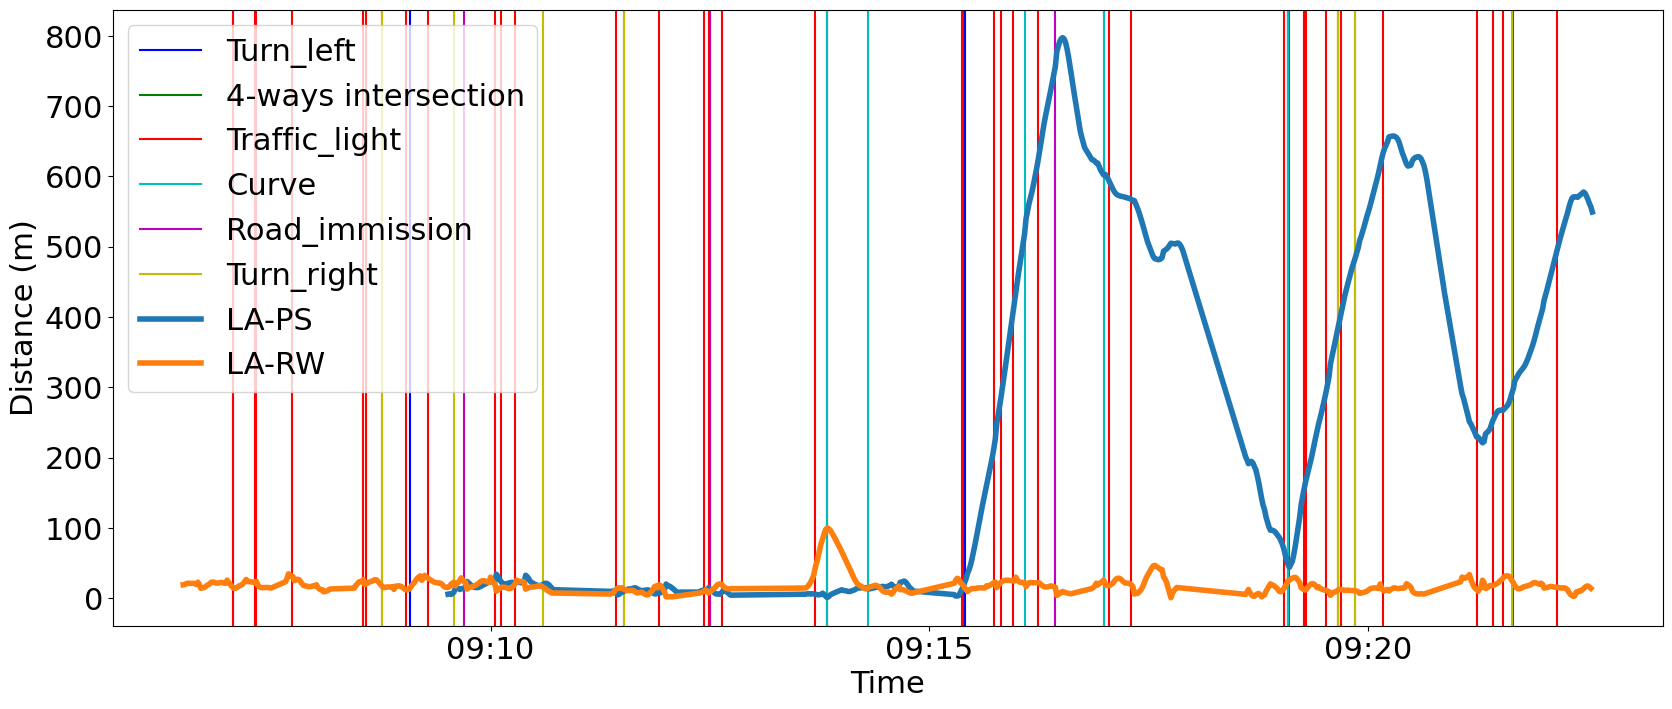

In [15]:
plt.figure(figsize = (20, 8))
plt.rcParams.update({'font.size': 22})
# plot feat
ref_driver_4_infr = drivers[0]
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in ref_driver_4_infr[ref_driver_4_infr[f]]['Time']:
        if first:
            plt.axvline(t,color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)

keys = list(distances.keys())
                
for k in keys:
    plt.plot(distances[k]['Time'],distances[k]['dist'],label=k,linewidth=4)
plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('Distance (m)')
plt.legend(loc='best')
#plt.savefig('images/dist.pdf',bbox_inches='tight')
plt.show()

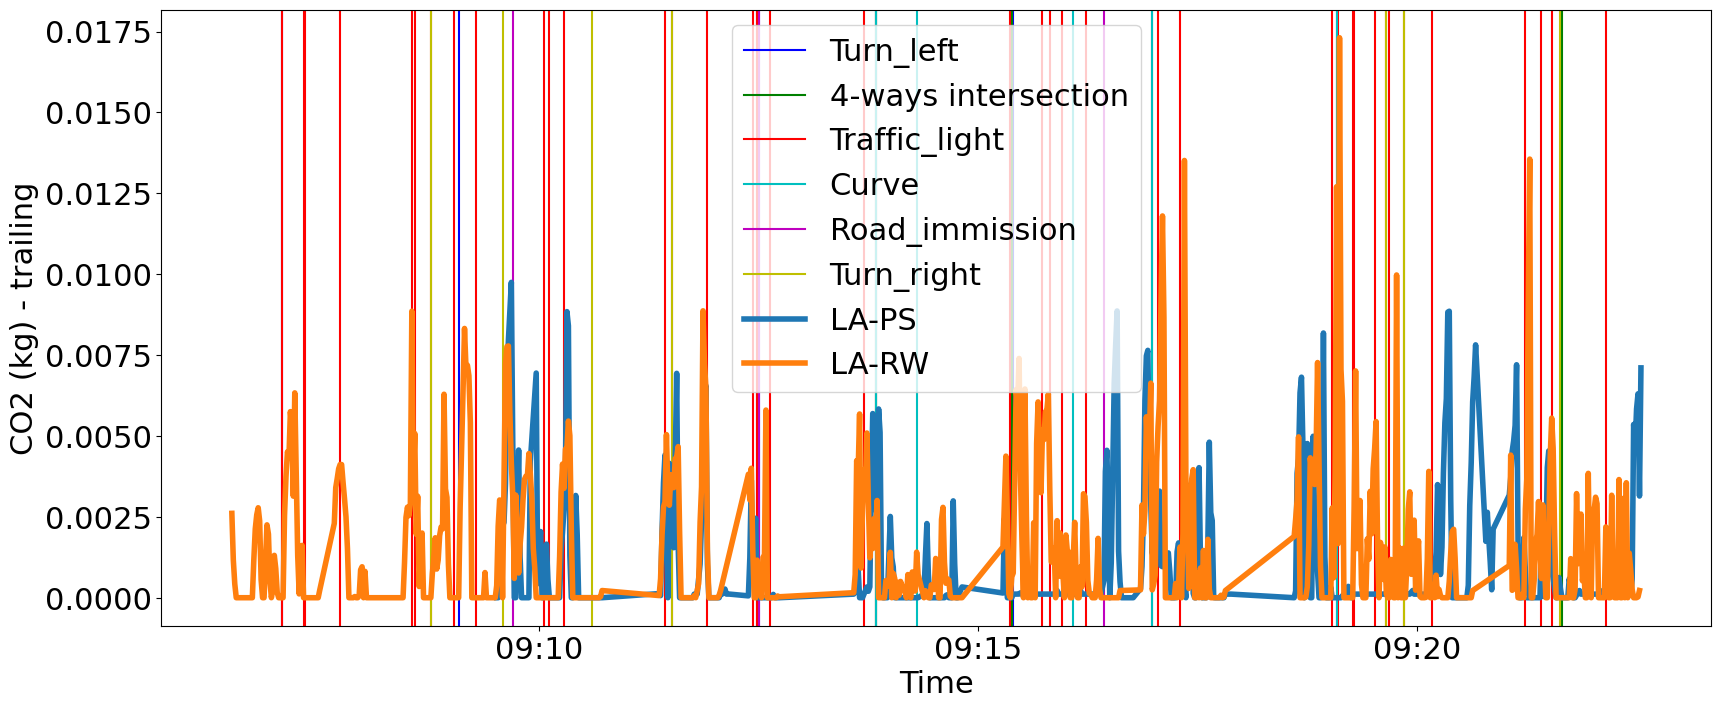

In [16]:
plt.figure(figsize = (20, 8))
plt.rcParams.update({'font.size': 22})
# plot feat
ref_driver_4_infr = drivers[0]
for i in range(len(feat)):
    first = True
    f = feat[i]
    c = list(mcolors.BASE_COLORS.values())[i]
    for t in ref_driver_4_infr[ref_driver_4_infr[f]]['Time']:
        if first:
            plt.axvline(t,color=c,label=f)
            first = False
        else:
             plt.axvline(t,color=c)

keys = list(distances.keys())
                
for k in keys:
    plt.plot(distances[k]['Time'],distances[k]['CO2[kg]'],label=k,linewidth=4)
plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('Time')
plt.ylabel('CO2 (kg) - trailing')
plt.legend(loc='best')
#plt.savefig('images/dist.pdf',bbox_inches='tight')
plt.show()

In [17]:
df = pd.concat(list(distances.values()))
#df = distances['LA-PS']
df.head(2)
X = df[['old_dist']+feat]
X = X.replace(True, 1)
X = X.replace(False, 0)
y = df['dist']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   dist   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     654.5
Date:                Sat, 05 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:29:21   Log-Likelihood:                -7567.3
No. Observations:                1264   AIC:                         1.515e+04
Df Residuals:                    1256   BIC:                         1.519e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  19.4279      3.236      6.004      0.000      13.080      25.776
old_dist                0.9165      0.014     67.573      0.000       0.890       0.943
Turn_left              50.2432     36.739      1.368      0.172     -21.833     122.319
4-ways intersection    39.1638     35.430      1.105      0.269     -30.344     108.671
Traffic_light         -21.0217     13.002     -1.617      0.106     -46.530       4.486
Curve                 -15.8658     35.633     -0.445      0.656     -85.772      54.041
Road_immission        -31.0777     36.512     -0.851      0.395    -102.710      40.554
Turn_right            -35.5005     30.366     -1.169      0.243     -95.074      24.073
==============================================================================
Omnibus:                      135.643   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              992.141
Skew:                           0.157   Prob(JB):                    3.62e-216
Kurtosis:                       7.329   Cond. No.                     3.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
y = df['CO2[kg]']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                CO2[kg]   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.433
Date:                Sat, 05 Aug 2023   Prob (F-statistic):            0.00121
Time:                        20:29:21   Log-Likelihood:                 6007.0
No. Observations:                1264   AIC:                        -1.200e+04
Df Residuals:                    1256   BIC:                        -1.196e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0012   7.01e-05     16.809      0.000       0.001       0.001
old_dist             6.186e-07   2.94e-07      2.104      0.036    4.17e-08     1.2e-06
Turn_left              -0.0011      0.001     -1.357      0.175      -0.003       0.000
4-ways intersection    -0.0008      0.001     -1.019      0.309      -0.002       0.001
Traffic_light           0.0010      0.000      3.684      0.000       0.000       0.002
Curve                   0.0017      0.001      2.174      0.030       0.000       0.003
Road_immission          0.0008      0.001      1.031      0.303      -0.001       0.002
Turn_right             -0.0005      0.001     -0.717      0.473      -0.002       0.001
==============================================================================
Omnibus:                      636.364   Durbin-Watson:                   0.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3934.998
Skew:                           2.307   Prob(JB):                         0.00
Kurtosis:                      10.310   Cond. No.                     3.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""